In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt

from statsmodels.tsa.ar_model import AR
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from datetime import date, datetime, timedelta
import sys

def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

# Generating non-stationary time series

In [230]:
data = pd.DataFrame(perdelta(date(2008, 1, 1), date(2018, 1, 31), timedelta(days = 1)), columns = ['date'])
data['time_index'] = data.index

data["yearmonth"] = data["date"].apply(lambda d: d.month)
data["monthday"] = data["date"].apply(lambda d: d.day)
data["weekday"] = data["date"].apply(lambda d: int(d.strftime("%w")))

data = data.set_index('date')

# Train/test split = 90%
split_index = int(0.9*len(data.index)) 

### Autoregression model AR 1

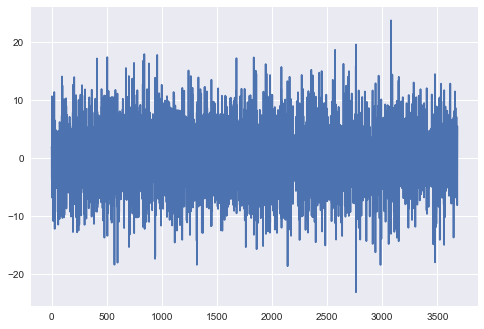

In [231]:
Init_value = 0
c0 = 0
c1 = -0.5
sigma = 5

y_clean = [Init_value]
for i in range(len(data.index)):
    y_clean.append(c0 + c1*y_clean[-1] + sigma*np.random.randn(1)[0])

data['y_clean'] = y_clean[1:]
    
pt.plot(data['time_index'], data['y_clean'])
pt.show()

### Non-linear deterministic trend

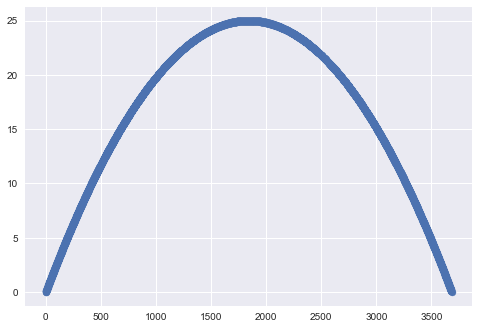

In [232]:
trend_scale = (c0/(1-c1) + 5*sigma)

def trend_shape(t):
    return trend_scale*(1 - 4*(t/len(data.index) - 0.5)**2)

data['trend'] = data['time_index'].apply(lambda t: trend_shape(t))

pt.scatter(data['time_index'], data['trend'])
pt.show()

### Monthly and daily multiplicative seasonality

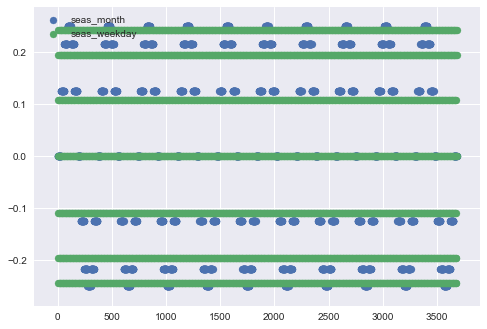

In [283]:
data["seas_yearmonth"] = 0.25 * np.sin((2*np.pi / 12) * (data['yearmonth']-1))
data["seas_weekday"] = 0.25 * np.sin((2*np.pi / 7) * data['weekday'])

pt.scatter(data['time_index'], data['seas_yearmonth'], label='seas_month')
pt.scatter(data['time_index'], data['seas_weekday'], label='seas_weekday')
pt.legend()
pt.show()

### Resulting time series

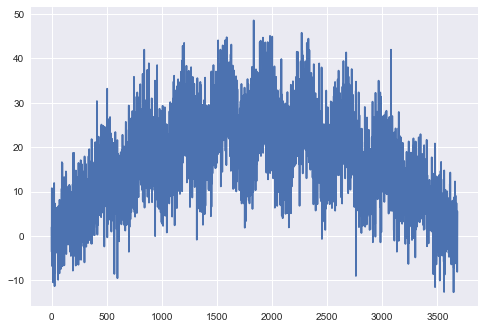

In [234]:
data["y"] = data['trend'] * (1 + data['seas_yearmonth'] + data['seas_weekday']) + data["y_clean"]
data["dy"] = data["y"] - data["y"].shift(1)
data.dropna(inplace=True)

pt.plot(data['time_index'], data['y'])
pt.show()

# Econometric approach: testing various specifications of linear model

### AR 1 model

In [235]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

In [236]:
estm = AR(data_train["y"]).fit(maxlag = 1)

const = estm.params['const']
coef = estm.params['L1.y']
print ("intercept: ", const, ", coef: ", coef)

y_pred = const + coef * data_test["y"].shift(1)[1:]
y_true = data_test["y"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  9.89350935094 , coef:  0.44784825441
MSE on the test dataset is 93.480.


### AR 1 model with differencing

In [237]:
estm = AR(data_train["dy"]).fit(maxlag = 1)

const = estm.params['const']
coef = estm.params['L1.dy']
print ("intercept: ", const, ", coef: ", coef)

y_pred = const + coef * data_test["dy"].shift(1)[1:]
y_true = data_test["dy"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  0.004256051758 , coef:  -0.640668465927
MSE on the test dataset is 40.240.


### AR 1 model with differencing and seasonality

In [238]:
Dummies = pd.get_dummies(100*data["yearmonth"]+data["weekday"]).add_prefix('seas_').iloc[:,1:]

Dummies_train = Dummies.iloc[:split_index]
Dummies_test = Dummies.iloc[split_index:]

In [239]:
exog = add_constant(pd.DataFrame(data_train["dy"].shift(1)).join(Dummies_train))
endog = data_train["dy"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['dy'])

y_pred = estm.predict(add_constant(pd.DataFrame(data_test["dy"].shift(1)).join(Dummies_test)))[1:]
y_true = data_test["dy"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  3.47670050691 , coef:  -0.732546829206
MSE on the test dataset is 51.409.


### AR 1 model with monthly MA trend and additive seasonality

In [240]:
MA_len = 30
data['y_MA'] = data['y'].rolling(window=MA_len).mean()

data_train = data.iloc[MA_len-1 : split_index]
data_test = data.iloc[split_index : ]

Dummies_train = Dummies.iloc[MA_len-1 : split_index]
Dummies_test = Dummies.iloc[split_index : ]

In [241]:
exog = add_constant(pd.DataFrame(data_train[["y","y_MA"]].shift(1)).join(Dummies_train))
endog = data_train["y"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['y'])

y_pred = estm.predict(add_constant(pd.DataFrame(data_test[["y","y_MA"]].shift(1)).join(Dummies_test)))[1:]
y_true = data_test["y"][1:]
score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

intercept:  0.713860676615 , coef:  -0.459362500694
MSE on the test dataset is 37.025.


### AR 1 model with monthly MA trend and multiplicative seasonality - TRUE SPECIFICATION

intercept:  0.901133940189 , coef:  -0.500263186207


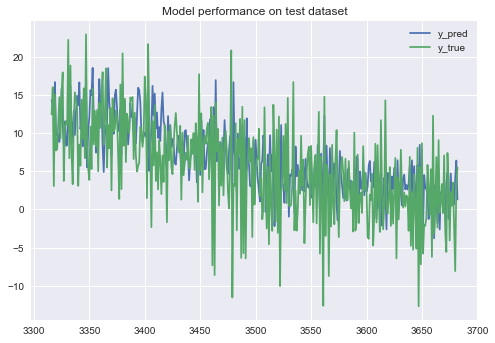

MSE on the test dataset is 25.406.


In [242]:
exog = add_constant(data_train[["y","y_MA"]].shift(1).join(Dummies_train.mul(data_train["y_MA"].shift(1), axis=0)))
endog = data_train["y"]
estm = OLS(endog = endog, exog = exog, missing = 'drop', hasconst = True).fit()

print ("intercept: ", estm.params['const'], ", coef: ", estm.params['y'])

y_pred = estm.predict(add_constant(
        data_test[["y","y_MA"]].shift(1).join(Dummies_test.mul(data_test["y_MA"].shift(1), axis=0))))[1:]
y_true = data_test["y"][1:]

pt.title('Model performance on test dataset')
pt.plot(data_test['time_index'][1:], y_pred, label='y_pred')
pt.plot(data_test['time_index'][1:], y_true, label='y_true')
pt.legend()
pt.show()

score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)

# Machine learning approach: fitting non-linear models with cross-validation

In [264]:
CV_splits = 50

### Step 1. Kernel regression for trend

Grid MSE scores on development set:
-62.162 (+/-35.236) for {'gamma': 1.1e-07}
-62.160 (+/-35.176) for {'gamma': 1.125e-07}
-62.159 (+/-35.125) for {'gamma': 1.15e-07}
-62.160 (+/-35.082) for {'gamma': 1.175e-07}
-62.162 (+/-35.047) for {'gamma': 1.2e-07}

Best MSE score is -62.159. Best parameters set found on development set:
{'gamma': 1.15e-07}


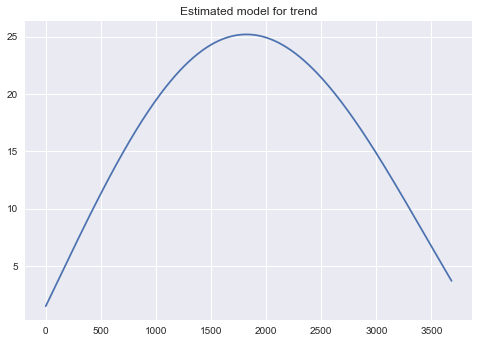

In [248]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s1 = KernelRidge(kernel = 'rbf')
tuned_parameters = [{'gamma': [1.100e-7, 1.125e-7, 1.150e-7, 1.175e-7, 1.200e-7]}]


grid = GridSearchCV(estimator=estm_s1, param_grid=tuned_parameters,
                   cv=TimeSeriesSplit(n_splits=CV_splits), scoring="neg_mean_squared_error")
grid.fit(data_train['time_index'].values.reshape(-1, 1), data_train['y'].values)

print("Grid MSE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MSE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

estm_s1.set_params(**grid.best_params_)
estm_s1.fit(data_train['time_index'].values.reshape(-1, 1), data_train["y"].values)


pt.title('Estimated model for trend')
pt.plot(data['time_index'], estm_s1.predict(data['time_index'].values.reshape(-1, 1)))
pt.show()

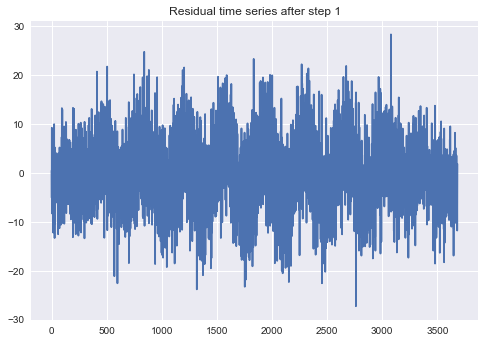

In [249]:
data['trend_est'] = estm_s1.predict(data['time_index'].values.reshape(-1, 1))
data['y_res1'] = data['y'] - data['trend_est']

pt.title('Residual time series after step 1')
pt.plot(data['time_index'], data['y_res1'])
pt.show()

### Step 2. Gradient boosting regression for seasonality

Grid MSE scores on development set:
-42.940 (+/-19.135) for {'n_estimators': 20, 'max_leaf_nodes': 3}
-42.355 (+/-18.738) for {'n_estimators': 22, 'max_leaf_nodes': 3}
-41.937 (+/-18.271) for {'n_estimators': 24, 'max_leaf_nodes': 3}
-41.610 (+/-18.289) for {'n_estimators': 26, 'max_leaf_nodes': 3}
-41.442 (+/-17.960) for {'n_estimators': 28, 'max_leaf_nodes': 3}
-41.037 (+/-17.898) for {'n_estimators': 30, 'max_leaf_nodes': 3}
-39.191 (+/-16.235) for {'n_estimators': 20, 'max_leaf_nodes': 7}
-39.071 (+/-16.608) for {'n_estimators': 22, 'max_leaf_nodes': 7}
-38.693 (+/-15.623) for {'n_estimators': 24, 'max_leaf_nodes': 7}
-38.654 (+/-16.053) for {'n_estimators': 26, 'max_leaf_nodes': 7}
-38.759 (+/-16.470) for {'n_estimators': 28, 'max_leaf_nodes': 7}
-38.864 (+/-16.893) for {'n_estimators': 30, 'max_leaf_nodes': 7}
-39.287 (+/-16.601) for {'n_estimators': 20, 'max_leaf_nodes': 12}
-38.845 (+/-15.891) for {'n_estimators': 22, 'max_leaf_nodes': 12}
-39.114 (+/-16.752) for {'n_estimators

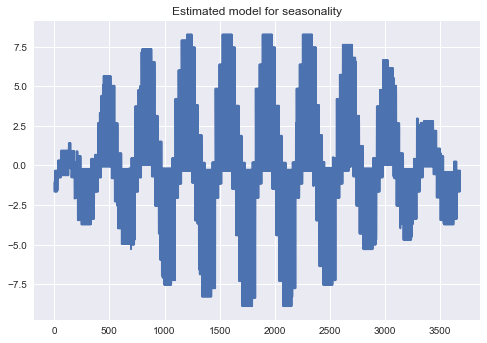

In [276]:
param = ['trend_est', 'yearmonth', 'monthday', 'weekday']

data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

# Restricting number of trees prevents overfitting
estm_s2 = GradientBoostingRegressor(max_features = 'auto', max_depth = len(param)-1)
tuned_parameters = [{'n_estimators': [20, 22, 24, 26, 28, 30], 'max_leaf_nodes': [3, 7, 12]}]


grid = GridSearchCV(estimator=estm_s2, param_grid=tuned_parameters,
                   cv=TimeSeriesSplit(n_splits=CV_splits), scoring="neg_mean_squared_error")
grid.fit(data_train[param], data_train['y_res1'])

print("Grid MSE scores on development set:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, 2 * std, params))
print()
print("Best MSE score is %0.3f." % grid.best_score_, "Best parameters set found on development set:")
print(grid.best_params_)

estm_s2.set_params(**grid.best_params_)
estm_s2.fit(data_train[param], data_train['y_res1'])


pt.title('Estimated model for seasonality')
pt.plot(data['time_index'], estm_s2.predict(data[param]))
pt.show()

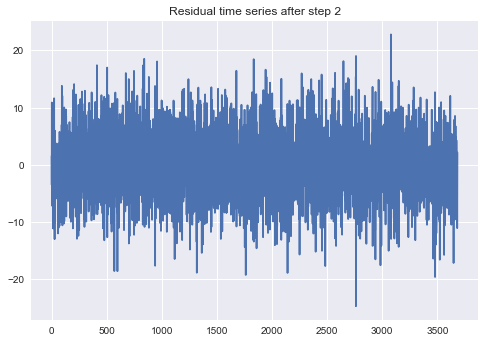

In [277]:
data['seas_est'] = estm_s2.predict(data[param])
data['y_res2'] = data['y_res1'] - data['seas_est']

pt.title('Residual time series after step 2')
pt.plot(data['time_index'], data['y_res2'])
pt.show()

### Step 3. ARMA model for residual stationary fluctuations

In [281]:
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

estm_s3 = AR(data_train["y_res2"]).fit(maxlag = 1)

const = estm_s3.params['const']
coef = estm_s3.params['L1.y_res2']
print ("intercept: ", const, ", coef: ", coef)

intercept:  -0.000633865782382 , coef:  -0.453987268124


### Step 4. Combining all machine learning models together

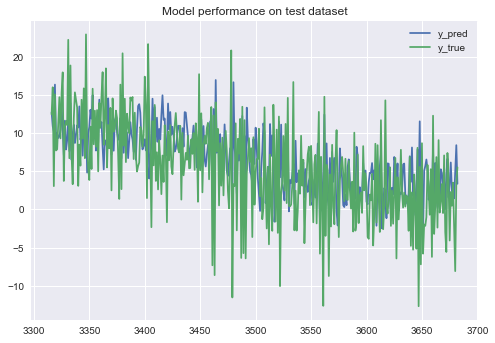

MSE on the test dataset is 25.874.


In [282]:
y_res2_pred = const + coef * data_test["y_res2"].shift(1)[1:]
y_res1_pred = y_res2_pred + estm_s2.predict(data_test[param])[1:]
y_pred = y_res1_pred + estm_s1.predict(data_test['time_index'].values.reshape(-1, 1))[1:]
y_true = data_test["y"][1:]

pt.title('Model performance on test dataset')
pt.plot(data_test['time_index'][1:], y_pred, label='y_pred')
pt.plot(data_test['time_index'][1:], y_true, label='y_true')
pt.legend()
pt.show()

score = mean_squared_error(y_pred = y_pred, y_true = y_true)
print ('MSE on the test dataset is %0.3f.' % score)